In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import tensorflow as tf
from tensorflow.keras import layers
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Directories
tumor_dir = r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/'
tumor_dir1 = r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/'
tumor_dir2 = r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/'
healthy_dir = r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/'

# Prepare filepaths and labels
filepaths = []
labels = []
dict_list = [tumor_dir, tumor_dir1, tumor_dir2, healthy_dir]
for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(str(i))  # Convert labels to strings

# Create DataFrame
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries, Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())
print(tumor_df.shape)

# Split dataset
train_images, test_images = train_test_split(tumor_df, test_size=0.15, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)


                                           filepaths labels
0  /kaggle/input/blood-cells/dataset2-master/data...      0
1  /kaggle/input/blood-cells/dataset2-master/data...      0
2  /kaggle/input/blood-cells/dataset2-master/data...      0
3  /kaggle/input/blood-cells/dataset2-master/data...      0
4  /kaggle/input/blood-cells/dataset2-master/data...      0
labels
3    2499
0    2497
1    2483
2    2478
Name: count, dtype: int64
(9957, 2)


In [ ]:
# Data Augmentation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Create Data Generators
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Adjusted to match the model input size
    color_mode='rgb',
    class_mode="sparse",  # For integer labels
    batch_size=32,
    shuffle=True  # Shuffle data for training
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Adjusted to match the model input size
    color_mode='rgb',
    class_mode="sparse",
    batch_size=32,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Adjusted to match the model input size
    color_mode='rgb',
    class_mode="sparse",
    batch_size=32,
    shuffle=False
)

Found 6770 validated image filenames belonging to 4 classes.
Found 1494 validated image filenames belonging to 4 classes.
Found 1693 validated image filenames belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class SiLUActivation(layers.Layer):
    def call(self, x):
        return tf.nn.silu(x)

class GELUActivation(layers.Layer):
    def call(self, x):
        return tf.nn.gelu(x)

class RelativeAttention(layers.Layer):
    def __init__(self, num_heads, hidden_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        
    def call(self, inputs):
        q, k, v = inputs
        batch_size = tf.shape(q)[0]
        height = tf.shape(q)[1]
        width = tf.shape(q)[2]
        depth = self.hidden_dim // self.num_heads
        
        def reshape_projection(x):
            return tf.reshape(x, [batch_size, height * width, self.num_heads, depth])
        
        q = reshape_projection(q)
        k = reshape_projection(k)
        v = reshape_projection(v)
        
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])
        
        scale = tf.cast(depth, tf.float32) ** -0.5
        attn = tf.matmul(q, k, transpose_b=True) * scale
        attn = tf.nn.softmax(attn)
        
        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])
        return tf.reshape(out, [batch_size, height, width, self.hidden_dim])

def mbconv(x, expand_ratio, output_channels, stride=1):
    input_channels = x.shape[-1]
    hidden_dim = input_channels * expand_ratio
    
    inputs = x
    x = layers.Conv2D(hidden_dim, 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = SiLUActivation()(x)
    
    x = layers.DepthwiseConv2D(3, stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = SiLUActivation()(x)
    
    x = layers.Conv2D(output_channels, 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    if stride == 1 and input_channels == output_channels:
        return layers.Add()([inputs, x])
    return x

def transformer_block(x, num_heads, hidden_dim, mlp_dim):
    inputs = x
    x = layers.LayerNormalization()(x)
    
    # Multi-head attention
    q = layers.Dense(hidden_dim)(x)
    k = layers.Dense(hidden_dim)(x)
    v = layers.Dense(hidden_dim)(x)
    
    attention_output = RelativeAttention(num_heads, hidden_dim)([q, k, v])
    attention_output = layers.Dense(hidden_dim)(attention_output)
    attention_output = layers.Dropout(0.1)(attention_output)
    x = layers.Add()([inputs, attention_output])
    
    # MLP block
    y = layers.LayerNormalization()(x)
    y = layers.Dense(mlp_dim)(y)
    y = GELUActivation()(y)
    y = layers.Dense(hidden_dim)(y)
    y = layers.Dropout(0.1)(y)
    
    return layers.Add()([x, y])

def coatnet(input_shape=(224, 224, 3), num_classes=4):
    num_blocks = [2, 2, 3, 5, 2]
    channels = [64, 96, 192, 384, 768]
    num_heads = [1, 1, 2, 4, 8]
    
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(channels[0], 7, 2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    for i in range(len(num_blocks)):
        for j in range(num_blocks[i]):
            if i < 2:
                x = mbconv(x, 4, channels[i])
            else:
                x = transformer_block(x, num_heads[i-2], channels[i], channels[i] * 4)
        if i < len(num_blocks) - 1:
            x = layers.Conv2D(channels[i+1], 3, 2, padding='same')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

# Create and compile model
model = coatnet(input_shape=(224, 224, 3), num_classes=4)

# Compile with appropriate loss and metrics
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Previous code remains the same until callbacks...

# Training configuration
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_coatnet_model.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=21,
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train,
    validation_data=val,
    epochs=25,
    callbacks=callbacks
)

# Optionally, save the final model
model.save('final_coatnet_model.keras')

In [24]:
import pandas as pd

def save_training_history_to_csv(history, filename='/kaggle/working/training_history.csv'):
    # Extract the data
    epochs = range(1, len(history.history['loss']) + 1)
    data = {
        'Epoch': epochs,
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy']
    }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f'Training history saved to {filename}')

# Use this function after training the model
save_training_history_to_csv(history)


Training history saved to /kaggle/working/training_history.csv


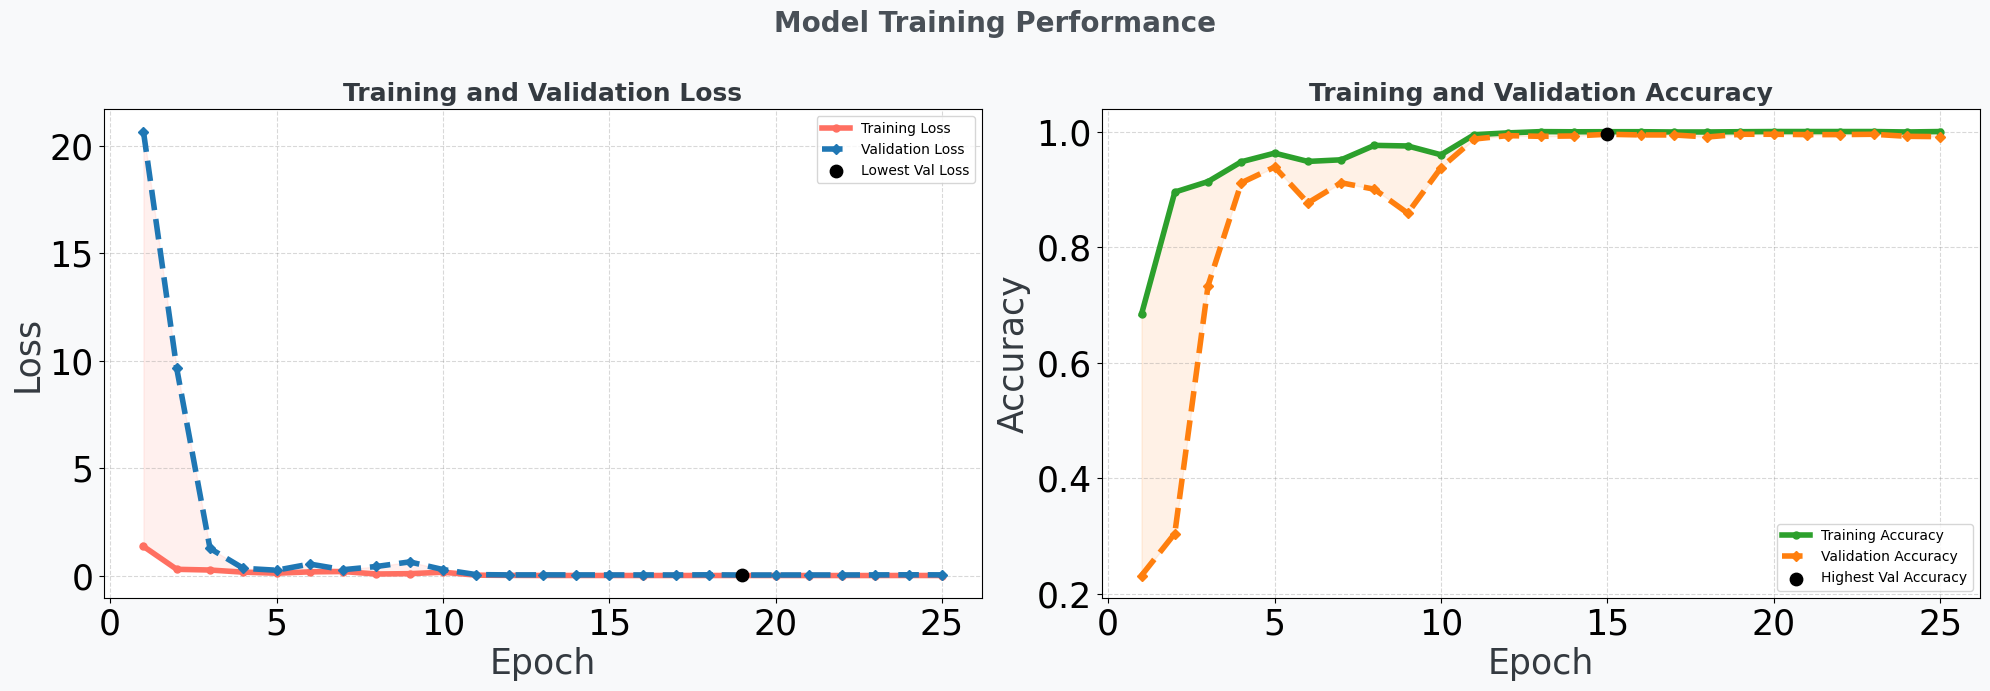

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    # Prepare data
    epochs = np.arange(1, len(history.history['loss']) + 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Create subplots with enhanced aesthetics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.patch.set_facecolor('#f8f9fa')  # Set background color for the figure

    # Font sizes
    axis_label_fontsize = 25
    tick_fontsize = 25

    # --- Loss Plot ---
    ax1.plot(epochs, train_loss, label='Training Loss', color='#ff6f61', marker='o', markersize=5, linewidth=4)
    ax1.plot(epochs, val_loss, label='Validation Loss', color='#1f77b4', marker='D', markersize=5, linestyle='--', linewidth=4)

    # Shaded area between train and validation loss
    ax1.fill_between(epochs, train_loss, val_loss, color='#ff6f61', alpha=0.1)
    ax1.set_title('Training and Validation Loss', fontsize=18, fontweight='bold', color='#343a40')
    ax1.set_xlabel('Epoch', fontsize=axis_label_fontsize, color='#343a40')
    ax1.set_ylabel('Loss', fontsize=axis_label_fontsize, color='#343a40')
    #ax1.legend(fontsize=-10, frameon=True, loc='upper right', facecolor='white', edgecolor='gray')
    ax1.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Highlight min validation loss
    min_val_loss_epoch = np.argmin(val_loss) + 1
    min_val_loss = val_loss[min_val_loss_epoch - 1]
    ax1.scatter(min_val_loss_epoch, min_val_loss, color='black', s=80, zorder=5, label='Lowest Val Loss')
    ax1.legend(loc='upper right')

    # --- Accuracy Plot ---
    ax2.plot(epochs, train_acc, label='Training Accuracy', color='#2ca02c', marker='o', markersize=5, linewidth=4)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', marker='D', markersize=5, linestyle='--', linewidth=4)

    # Shaded area between train and validation accuracy
    ax2.fill_between(epochs, train_acc, val_acc, color='#ff7f0e', alpha=0.1)
    ax2.set_title('Training and Validation Accuracy', fontsize=18, fontweight='bold', color='#343a40')
    ax2.set_xlabel('Epoch', fontsize=axis_label_fontsize, color='#343a40')
    ax2.set_ylabel('Accuracy', fontsize=axis_label_fontsize, color='#343a40')
    #ax2.legend(fontsize=10, frameon=True, loc='lower right', facecolor='white', edgecolor='gray')
    ax2.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Highlight max validation accuracy
    max_val_accuracy_epoch = np.argmax(val_acc) + 1
    max_val_accuracy = val_acc[max_val_accuracy_epoch - 1]
    ax2.scatter(max_val_accuracy_epoch, max_val_accuracy, color='black', s=80, zorder=5, label='Highest Val Accuracy')
    ax2.legend(loc='lower right')

    # Set a common super title
    fig.suptitle('Model Training Performance', fontsize=20, fontweight='bold', color='#495057')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_training_history(history)

In [ ]:
y_pred_proba = model.predict(test, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test.labels

In [44]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.99      0.99      0.99       386
  LYMPHOCYTE       1.00      1.00      1.00       381
    MONOCYTE       1.00      1.00      1.00       353
  NEUTROPHIL       0.99      0.98      0.99       374

    accuracy                           0.99      1494
   macro avg       0.99      0.99      0.99      1494
weighted avg       0.99      0.99      0.99      1494



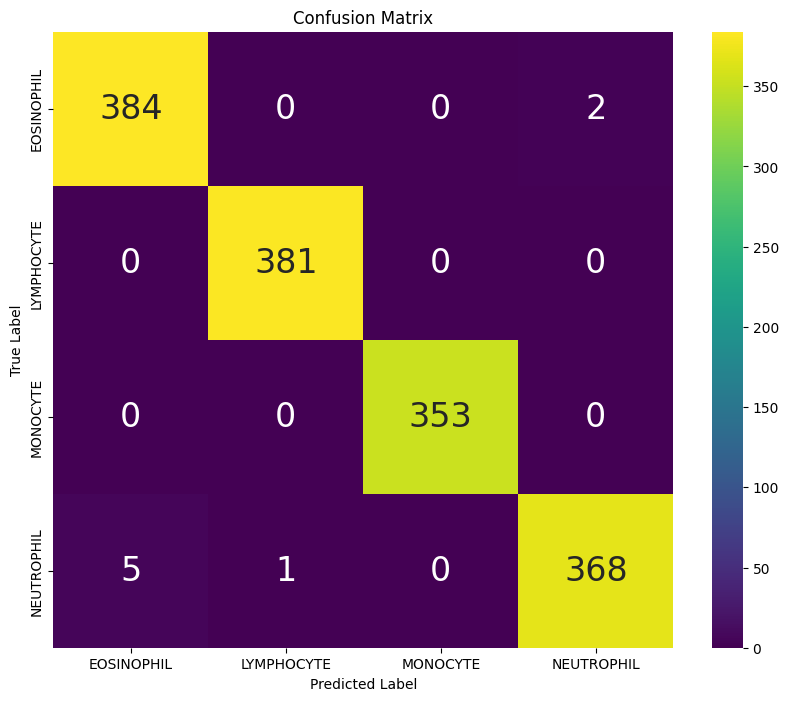

In [50]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 24},
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion_matrix(y_true, y_pred, class_names)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

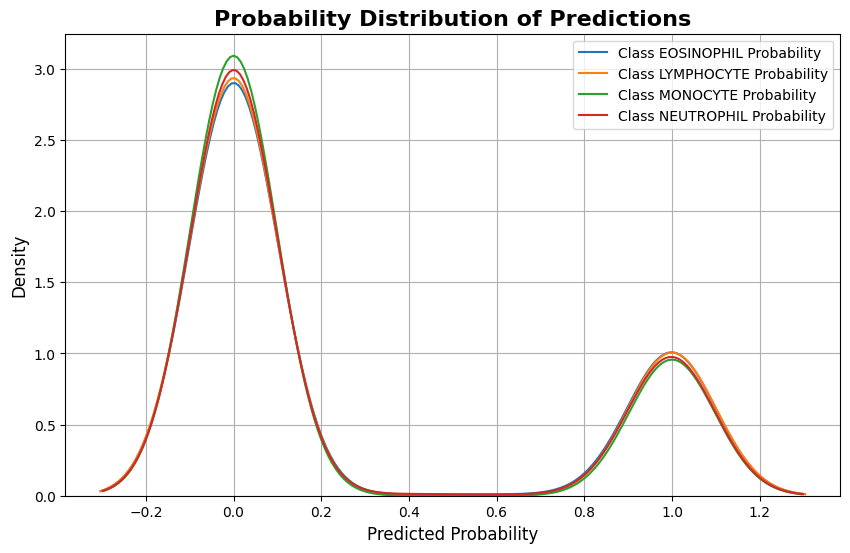

In [52]:
def plot_probability_distribution(y_pred_proba):
    plt.figure(figsize=(10, 6))
    
    # Plot the probability distributions for each class
    for i in range(len(class_names)):
        sns.kdeplot(y_pred_proba[:, i], label=f'Class {class_names[i]} Probability')
    
    plt.title('Probability Distribution of Predictions', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)
    plt.show()

# Get predicted probabilities
plot_probability_distribution(y_pred_proba)

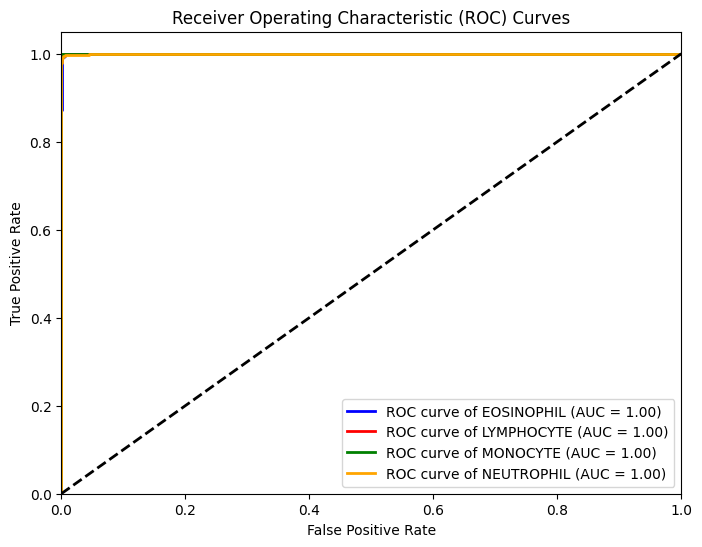

In [57]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, class_names):
    n_classes = len(class_names)
    y_true_bin = tf.keras.utils.to_categorical(y_true, n_classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(y_true, y_pred_proba, class_names)


Correct Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1759143327.381957     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1759143327.383606     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1759143327.385241     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Total predictions: 32
Correct predictions: 31


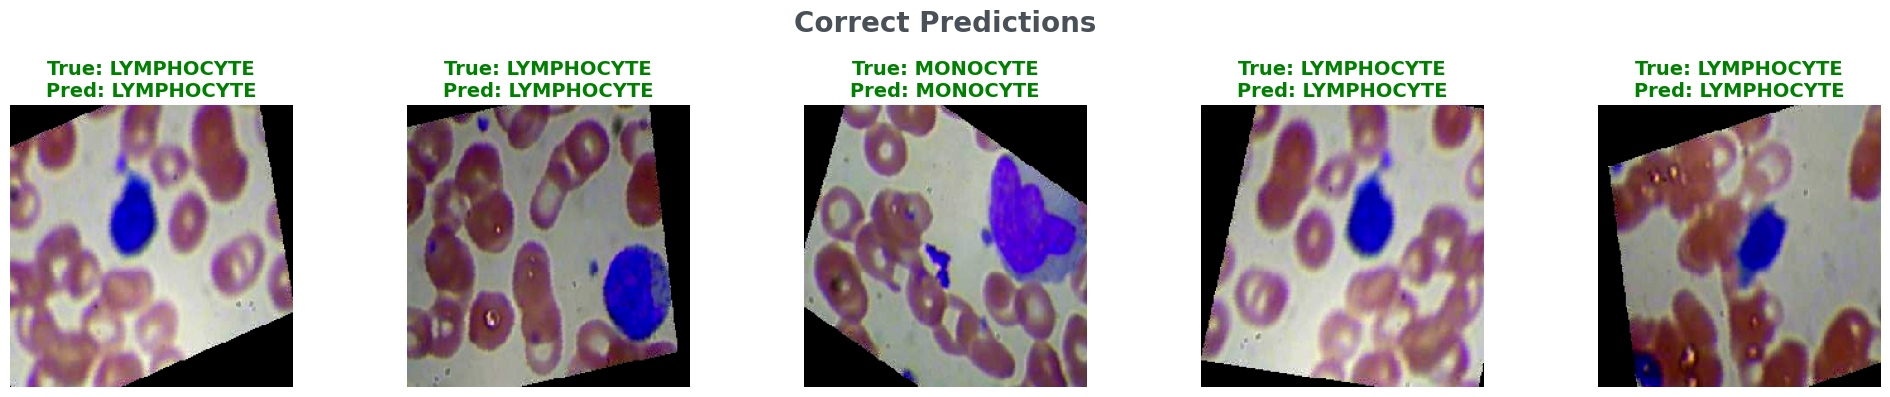

In [54]:
def plot_correct_predictions(test_generator, model, class_names, num_samples=5):
    # Get a batch of test images
    test_generator.reset()
    batch_x, batch_y = next(test_generator)
    predictions = model.predict(batch_x)
    pred_classes = np.argmax(predictions, axis=1)
    
    # Calculate correct indices
    correct_idx = np.where(pred_classes == batch_y)[0]

    # Print counts for debugging
    print(f'Total predictions: {len(pred_classes)}')
    print(f'Correct predictions: {len(correct_idx)}')

    # If there are no correct predictions, print a message and return
    if len(correct_idx) == 0:
        print("No correct predictions in this batch.")
        return

    # Limit to the number of samples requested or available correct predictions
    num_samples = min(num_samples, len(correct_idx))

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

    for i in range(num_samples):
        idx = correct_idx[i]
        ax = axes[i]
        ax.imshow(batch_x[idx])
        ax.axis('off')
        ax.set_title(f'True: {class_names[int(batch_y[idx])]}\nPred: {class_names[pred_classes[idx]]}',
                     color='green', fontsize=14, fontweight='bold')

    plt.suptitle('Correct Predictions', fontsize=20, fontweight='bold', color='#495057')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function to plot correct predictions
print("\nCorrect Predictions:")
plot_correct_predictions(test, model, class_names)
